In [1]:
import pandas as pd
import numpy as np
import pyximport
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True)
from algorithms.knn_neighborhood import UserKNN
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from collections import defaultdict

In [2]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, details in predictions:
        if not details["was_impossible"]:
            top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = [iid for iid, _ in user_ratings[:n]]

    return top_n

In [3]:
def mann_whitney_u_test(x, y, alternative="two-sided"):
    u, p = mannwhitneyu(x, y, alternative=alternative)
    nx = len(x)
    ny = len(y)
    mu_u = (nx * ny) / 2
    sigma_u = np.sqrt(nx * ny * (nx + ny + 1) / 12)
    z = (u - mu_u) / sigma_u
    n = len(x) + len(y)
    r = z / np.sqrt(n)
    return u, p, r

In [4]:
#df = pd.read_csv("data/ml-100k/ml-100k/u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])
#df.drop(columns=["timestamp"], inplace=True)

df = pd.read_csv("data/ml-1m/ratings.dat", sep="::", names=["user_id", "item_id", "rating", "timestamp"])
df.drop(columns=["timestamp"], inplace=True)
relevant_users = np.random.choice(df["user_id"].nunique(), size=1000, replace=False)
df = df[df["user_id"].isin(relevant_users)]

df.head()

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


,user_id,item_id,rating
554,8,39,3
555,8,2336,3
556,8,288,5
557,8,3425,3
558,8,2268,3


In [5]:
dataset = Dataset.load_from_df(df, reader=Reader(rating_scale=(1, 5)))
trainset, testset = train_test_split(dataset, test_size=0.2)

In [6]:
item_popularity = np.zeros(trainset.n_items)
for iid, ratings in trainset.ir.items():
    item_popularity[iid] += len(ratings)
item_popularity /= trainset.n_users

In [7]:
avg_itempop_per_user = np.zeros(trainset.n_users)
for uid, ratings in trainset.ur.items():
    avg_itempop_per_user[uid] = np.mean([item_popularity[iid] for iid, _ in ratings])
avg_itempop_per_user

array([0.12982913, 0.14602761, 0.08967893, 0.1491642 , 0.08704227,
       0.10041414, 0.14098076, 0.13094344, 0.11722834, 0.10811329,
       0.09293633, 0.1021307 , 0.17278148, 0.10219134, 0.09737296,
       0.08134668, 0.12192474, 0.12999842, 0.11124458, 0.06746083,
       0.13780447, 0.09334495, 0.11569431, 0.08196802, 0.08182208,
       0.12615247, 0.10804421, 0.12158036, 0.0862898 , 0.18011951,
       0.13348385, 0.13032705, 0.13631022, 0.11417985, 0.09265265,
       0.10392033, 0.09188422, 0.09876543, 0.12616821, 0.14343413,
       0.14135564, 0.08880138, 0.10086937, 0.11796797, 0.09229459,
       0.12693775, 0.12074175, 0.08946621, 0.09094399, 0.11889309,
       0.10907222, 0.09079534, 0.09368564, 0.13571724, 0.13020071,
       0.11906113, 0.08264694, 0.12622271, 0.08061395, 0.1147824 ,
       0.09182993, 0.10585034, 0.13417635, 0.11343619, 0.12359266,
       0.07251627, 0.14105444, 0.07036305, 0.12299698, 0.11078579,
       0.09935287, 0.1127984 , 0.11719828, 0.11282711, 0.11727

In [8]:
K = [5, 10, 15, 20, 25, 30]
avg_gap_userknn, avg_gap_reuseknn = [], []
for k in K:
    model = UserKNN(k=k, protected=False)
    model.fit(trainset)
    predictions = model.test(testset)

    avg_recpop_per_user = np.zeros(trainset.n_users)
    for ruid, recs in get_top_n(predictions, n=10).items():
        iuid = trainset.to_inner_uid(ruid)
        pop = []
        for riid in recs:
            iiid = trainset.to_inner_iid(riid)
            pop.append(item_popularity[iiid])
        avg_recpop_per_user[iuid] = np.mean(pop)
    gap_userknn = (avg_recpop_per_user - avg_itempop_per_user) / avg_itempop_per_user

    model = UserKNN(k=k, reuse=False, tau_2=True, protected=False)
    model.fit(trainset)
    predictions = model.test(testset)

    avg_recpop_per_user_ = np.zeros(trainset.n_users)
    for ruid, recs in get_top_n(predictions, n=10).items():
        iuid = trainset.to_inner_uid(ruid)
        pop = []
        for riid in recs:
            iiid = trainset.to_inner_iid(riid)
            pop.append(item_popularity[iiid])
        avg_recpop_per_user_[iuid] = np.mean(pop)
    gap_reuseknn = (avg_recpop_per_user_ - avg_itempop_per_user) / avg_itempop_per_user
    
    
    avg_gap_userknn.append(np.mean(gap_userknn))
    avg_gap_reuseknn.append(np.mean(gap_reuseknn))
    
    u, p, r = mann_whitney_u_test(gap_userknn, gap_reuseknn, alternative="two-sided")
    print(p, r)

7.874957703472981e-05 -0.08832888855420329
6.58408417822212e-08 -0.1208574126060606
2.492674820918284e-07 -0.11540056725904947
0.0006561034942239374 -0.07622839906292962
0.025702131925480425 -0.04990540995020915
0.22872886150987126 -0.026928534113072437


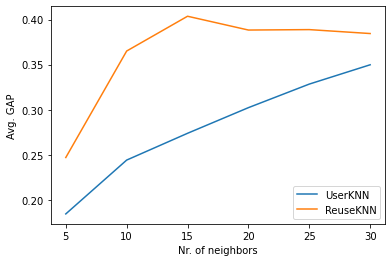

In [9]:
plt.plot(K, avg_gap_userknn, label="UserKNN")
plt.plot(K, avg_gap_reuseknn, label="ReuseKNN")
plt.ylabel("Avg. GAP")
plt.xlabel("Nr. of neighbors")
plt.legend()

In [11]:
K = [5, 10, 15, 20, 25, 30]
avg_pop_userknn, avg_pop_reuseknn = [], []
for k in K:
    model = UserKNN(k=k, protected=False)
    model.fit(trainset)
    predictions = model.test(testset)

    avg_recpop_per_user = np.zeros(trainset.n_users)
    for ruid, recs in get_top_n(predictions, n=10).items():
        iuid = trainset.to_inner_uid(ruid)
        pop = []
        for riid in recs:
            iiid = trainset.to_inner_iid(riid)
            pop.append(item_popularity[iiid])
        avg_recpop_per_user[iuid] = np.mean(pop)
        

    model = UserKNN(k=k, reuse=True, tau_2=True, protected=False)
    model.fit(trainset)
    predictions = model.test(testset)

    avg_recpop_per_user_ = np.zeros(trainset.n_users)
    for ruid, recs in get_top_n(predictions, n=10).items():
        iuid = trainset.to_inner_uid(ruid)
        pop = []
        for riid in recs:
            iiid = trainset.to_inner_iid(riid)
            pop.append(item_popularity[iiid])
        avg_recpop_per_user_[iuid] = np.mean(pop)
    
    avg_pop_userknn.append(avg_recpop_per_user)
    avg_pop_reuseknn.append(avg_recpop_per_user_)
    
    u, p, r = mann_whitney_u_test(avg_recpop_per_user, avg_recpop_per_user_, alternative="two-sided")
    print(p, r)

9.881758508196213e-17 -0.18582597132576964
6.649044395950568e-12 -0.15358373645745982
1.090797246871121e-09 -0.13636908109645154
4.324395129599859e-07 -0.11307034681356903
0.00012531667375395182 -0.08580780865302454
0.004432364614026971 -0.06366290653413642


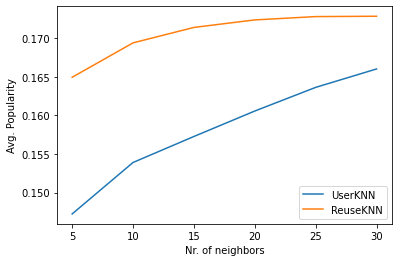

In [12]:
plt.plot(K, [np.mean(x) for x in avg_pop_userknn], label="UserKNN")
plt.plot(K, [np.mean(x) for x in avg_pop_reuseknn], label="ReuseKNN")
plt.ylabel("Avg. Popularity")
plt.xlabel("Nr. of neighbors")
plt.legend()